In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import circmean,ks_2samp

In [2]:
from fly2p_function_TQ.imaging_2p_write_in_pair_analysis import run_write_in_pair_analysis_across_trial

In [3]:
data = run_write_in_pair_analysis_across_trial('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/EPG_write_in/SS00096_7f_CsCHtdT/for analysis/180','/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/EPG_write_in/SS00096_7f_CsCHtdT/for analysis/180-stimulation-index',"TQfly")

In [114]:
def plot_aligned_pva_walk_stop(
    pva_1st,
    pva_2nd,
    stop_stamp,
    strength_data=None,
    strength_threshold=None,
    split_by_pva_bin3=False,
    pva_threshold=0.79
):
    # Combine and process
    combined_pva = pd.concat([pva_1st, pva_2nd], axis=1).to_numpy()
    stop_stamp = stop_stamp.to_numpy().flatten()
    aligned_pva = np.full_like(combined_pva, np.nan)

    for i in range(combined_pva.shape[0]):
        first_three = combined_pva[i, :3]
        if np.isnan(first_three).any():
            continue
        baseline = circmean(first_three, high=np.pi, low=-np.pi)
        shifted = combined_pva[i, :] - baseline
        aligned_pva[i, :] = np.angle(np.exp(1j * shifted))

    # Filter invalid trials
    valid_mask = ~np.isnan(aligned_pva).any(axis=1)
    if strength_data is not None and strength_threshold is not None:
        strength_vals = strength_data.to_numpy()
        avg_strength = np.nanmean(strength_vals, axis=1)
        valid_mask &= avg_strength >= strength_threshold

    aligned_pva = aligned_pva[valid_mask]
    stop_stamp = stop_stamp[valid_mask]

    if strength_data is not None and strength_threshold is not None:
        strength_data = strength_data[valid_mask]

    aligned_abs = np.abs(aligned_pva)
    walk_trials = aligned_abs[stop_stamp == 1]
    stop_trials = aligned_abs[stop_stamp == 0]

    if split_by_pva_bin3:
        walk_low = walk_trials[walk_trials[:, 3] < pva_threshold]
        walk_high = walk_trials[walk_trials[:, 3] >= pva_threshold]
        stop_low = stop_trials[stop_trials[:, 3] < pva_threshold]
        stop_high = stop_trials[stop_trials[:, 3] >= pva_threshold]
    else:
        walk_low, walk_high = walk_trials, np.empty((0, walk_trials.shape[1]))
        stop_low, stop_high = stop_trials, np.empty((0, stop_trials.shape[1]))

    # Plot
    plt.figure(figsize=(10, 6))

    for row in walk_low:
        plt.plot(row, color='navy', alpha=0.15, linewidth=1)
    for row in walk_high:
        plt.plot(row, color='blue', alpha=0.15, linewidth=1)
    for row in stop_low:
        plt.plot(row, color='darkred', alpha=0.15, linewidth=1)
    for row in stop_high:
        plt.plot(row, color='red', alpha=0.15, linewidth=1)

    if len(walk_low) > 0:
        plt.plot(np.mean(walk_low, axis=0), color='navy', linewidth=4, label='Walk |PVA| < pi/4')
    if len(walk_high) > 0:
        plt.plot(np.mean(walk_high, axis=0), color='blue', linewidth=4, label='Walk |PVA| ≥ pi/4')
    if len(stop_low) > 0:
        plt.plot(np.mean(stop_low, axis=0), color='darkred', linewidth=4, label='Stop |PVA| < pi/4')
    if len(stop_high) > 0:
        plt.plot(np.mean(stop_high, axis=0), color='red', linewidth=4, label='Stop |PVA| ≥ pi/4')

    if not split_by_pva_bin3:
        if len(walk_low) > 0:
            plt.plot(np.mean(walk_low, axis=0), color='green', linewidth=4, label='Walk')
        if len(stop_low) > 0:
            plt.plot(np.mean(stop_low, axis=0), color='orange', linewidth=4, label='Stop')

    plt.axvline(x=2, color='red', linestyle='--', label='2nd Stimulation Onset')
    plt.xlabel("Time Bin (200 ms each)")
    plt.ylabel("|Aligned PVA| (rad)")
    plt.title("Absolute Circularly Aligned PVA - Walk vs Stop Trials" + 
              ("\nSplit by Bin 3 Threshold" if split_by_pva_bin3 else "") +
              (f"\nFiltered by Strength > {strength_threshold}" if strength_threshold else ""))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(ticks=np.arange(combined_pva.shape[1]), labels=[str(i) for i in range(combined_pva.shape[1])])
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
np.mean(data['Bump_amplitude_at_stop'])

0.6866070975152588

In [6]:
np.mean(data['Bump_amplitude_at_turn'])

0.7678487348496388

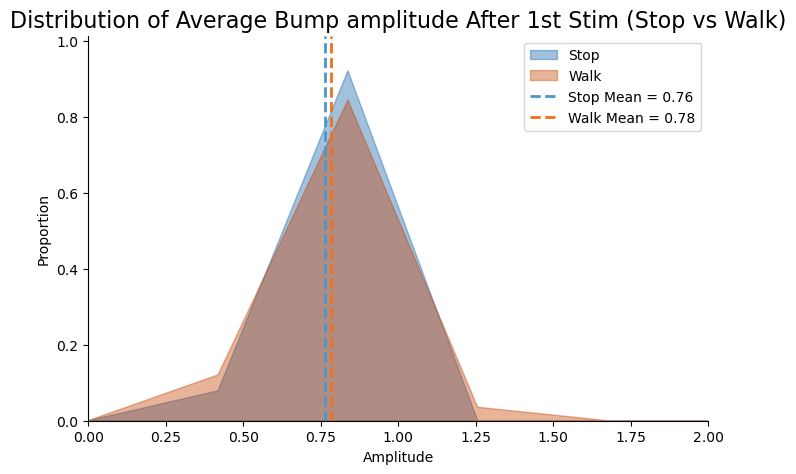

In [12]:
# Define bins
bins = np.linspace(-np.pi, np.pi, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['average_Bump_amplitude_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['average_Bump_amplitude_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(stop_data, bins=bins)
hist_walk, _ = np.histogram(walk_data, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute circular means, ignoring NaNs
circ_mean_stop = circmean(stop_data.dropna(), high=np.pi, low=-np.pi)
circ_mean_walk = circmean(walk_data.dropna(), high=np.pi, low=-np.pi)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

# Plot circular means as dashed lines
ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xlabel("Amplitude")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Distribution of Average Bump amplitude After 1st Stim (Stop vs Walk)", fontsize=16)

plt.show()


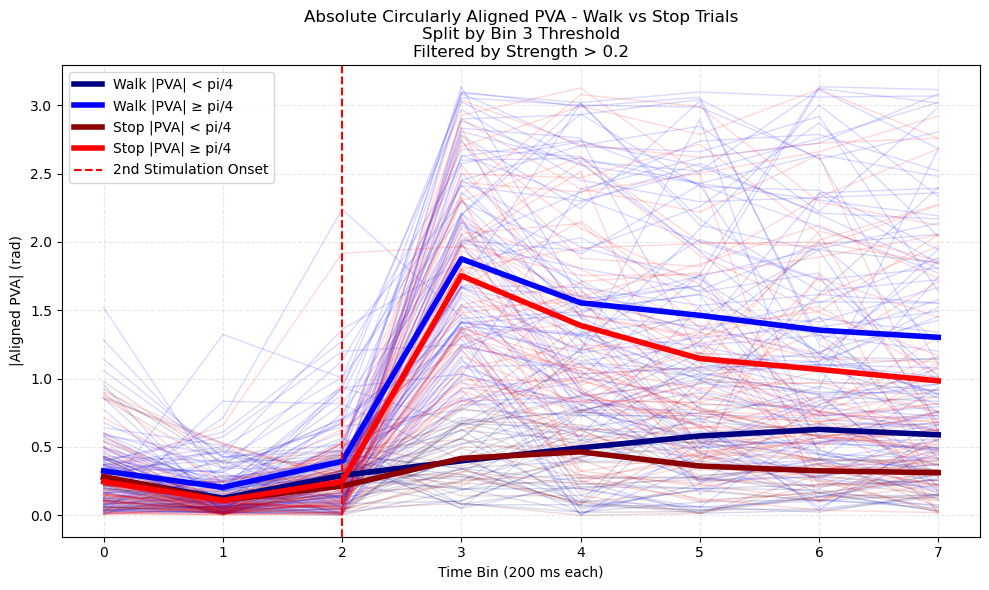

In [115]:
plot_aligned_pva_walk_stop(
    pva_1st=data['200ms_bin_PVA_after_1st_stim'],
    pva_2nd=data['200ms_bin_PVA_after_2nd_stim'],
    stop_stamp=data['stop_stamp_after_2nd_stim'],
    strength_data=data['200ms_bin_strength_after_2nd_stim'],
    strength_threshold=0.2,
    split_by_pva_bin3=True,
    pva_threshold=0.79
)

In [116]:
data['stop_stamp_after_2nd_stim']

,0
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
225,1.0
226,1.0
227,0.0
228,0.0


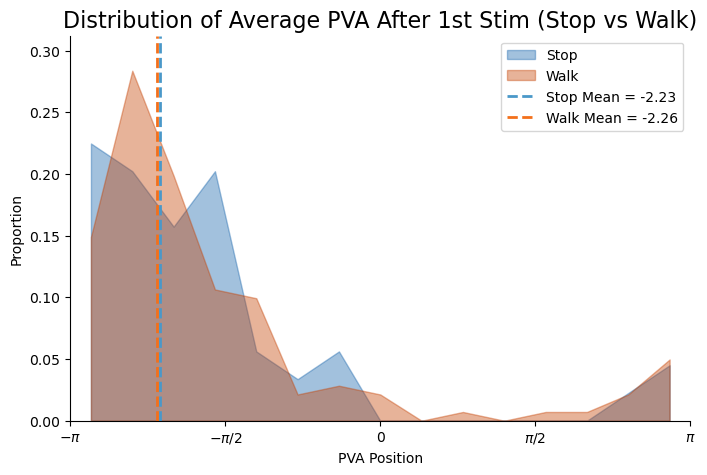

In [117]:
# Define bins
bins = np.linspace(-np.pi, np.pi, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['average_PVA_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['average_PVA_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(stop_data, bins=bins)
hist_walk, _ = np.histogram(walk_data, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute circular means, ignoring NaNs
circ_mean_stop = circmean(stop_data.dropna(), high=np.pi, low=-np.pi)
circ_mean_walk = circmean(walk_data.dropna(), high=np.pi, low=-np.pi)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

# Plot circular means as dashed lines
ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
ax.set_xlabel("PVA Position")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Distribution of Average PVA After 1st Stim (Stop vs Walk)", fontsize=16)

plt.show()


Stop trials before: 89, after filtering: 76
Walk trials before: 141, after filtering: 119


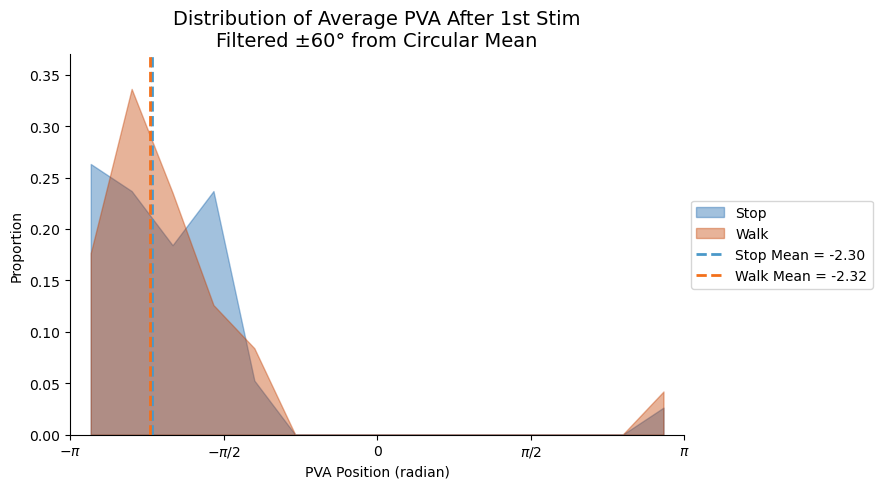

In [118]:
# Extract raw data
stop_data = data['average_PVA_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna().to_numpy()
walk_data = data['average_PVA_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna().to_numpy()

# Combine to compute overall circular mean
all_data = np.concatenate([stop_data, walk_data])
circular_mean = circmean(all_data, high=np.pi, low=-np.pi)

# Compute circular distance from mean
def circ_distance(a, b):
    return np.angle(np.exp(1j * (a - b)))  # difference wrapped to [-π, π]

# Define threshold (±60 degrees in radians)
threshold_rad = np.deg2rad(60)

# Apply filtering
stop_dev = np.abs(circ_distance(stop_data, circular_mean))
walk_dev = np.abs(circ_distance(walk_data, circular_mean))

stop_data_filtered = stop_data[stop_dev <= threshold_rad]
walk_data_filtered = walk_data[walk_dev <= threshold_rad]

# Report exclusions
print(f"Stop trials before: {len(stop_data)}, after filtering: {len(stop_data_filtered)}")
print(f"Walk trials before: {len(walk_data)}, after filtering: {len(walk_data_filtered)}")

# Compute histograms
hist_stop, _ = np.histogram(stop_data_filtered, bins=bins)
hist_walk, _ = np.histogram(walk_data_filtered, bins=bins)

hist_stop = hist_stop / hist_stop.sum() if hist_stop.sum() > 0 else hist_stop
hist_walk = hist_walk / hist_walk.sum() if hist_walk.sum() > 0 else hist_walk

bin_centers = (bins[:-1] + bins[1:]) / 2

# Circular means of filtered groups
circ_mean_stop = circmean(stop_data_filtered, high=np.pi, low=-np.pi) if len(stop_data_filtered) > 0 else np.nan
circ_mean_walk = circmean(walk_data_filtered, high=np.pi, low=-np.pi) if len(walk_data_filtered) > 0 else np.nan

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

if not np.isnan(circ_mean_stop):
    ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='--', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
if not np.isnan(circ_mean_walk):
    ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='--', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0, max(max(hist_stop, default=0), max(hist_walk, default=0)) * 1.1)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
ax.set_xlabel("PVA Position (radian)")
ax.set_ylabel("Proportion")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Distribution of Average PVA After 1st Stim\nFiltered ±60° from Circular Mean", fontsize=14)

# Adjust legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [119]:
def filter_pva_by_circular_distance(pva_series: pd.Series, threshold_deg: float = 60) -> pd.Series:
    """
    Filters a Series of circular PVA values by excluding values that deviate more than a threshold (in degrees)
    from the circular mean.

    Parameters:
        pva_series (pd.Series): Series of PVA values in radians [-π, π].
        threshold_deg (float): Threshold in degrees (default 60).

    Returns:
        pd.Series: Filtered PVA values, with outliers replaced with NaN (preserving original index).
    """
    # Drop NaNs first for computation
    pva_clean = pva_series.dropna().to_numpy()
    circ_mean = circmean(pva_clean, high=np.pi, low=-np.pi)
    threshold_rad = np.deg2rad(threshold_deg)

    # Define circular distance
    def circ_distance(a, b):
        return np.angle(np.exp(1j * (a - b)))  # wrapped to [-π, π]

    deviations = np.abs(circ_distance(pva_series, circ_mean))
    filtered_series = pva_series.copy()
    filtered_series[deviations > threshold_rad] = np.nan  # Drop if beyond threshold

    return filtered_series

In [120]:
data['average_PVA_after_1st_stim_filtered'] = filter_pva_by_circular_distance(data['average_PVA_after_1st_stim'])

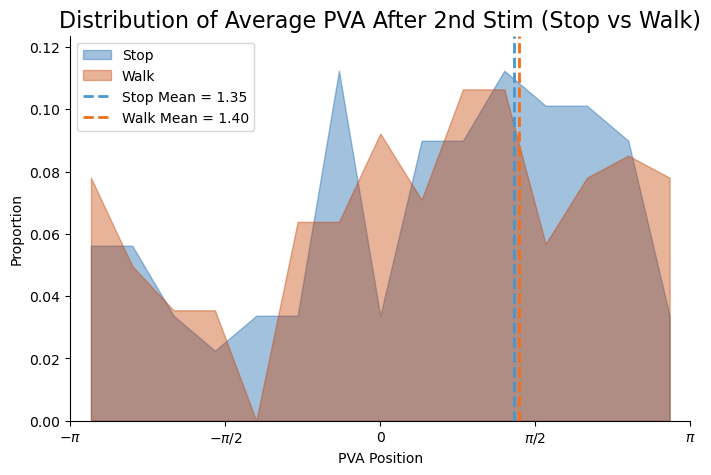

In [121]:
# Define bins
bins = np.linspace(-np.pi, np.pi, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['average_PVA_after_2nd_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['average_PVA_after_2nd_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(stop_data, bins=bins)
hist_walk, _ = np.histogram(walk_data, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute circular means, ignoring NaNs
circ_mean_stop = circmean(stop_data.dropna(), high=np.pi, low=-np.pi)
circ_mean_walk = circmean(walk_data.dropna(), high=np.pi, low=-np.pi)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

# Plot circular means as dashed lines
ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
ax.set_xlabel("PVA Position")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Distribution of Average PVA After 2nd Stim (Stop vs Walk)", fontsize=16)

plt.show()

In [122]:
np.mean(data['average_PVA_after_1st_stim'])

-1.7014219446804795

In [123]:
# Calculate the circular difference
data['PVA_difference'] = (data['average_PVA_after_2nd_stim'] - data['average_PVA_after_1st_stim_filtered'] + np.pi) % (2 * np.pi) - np.pi

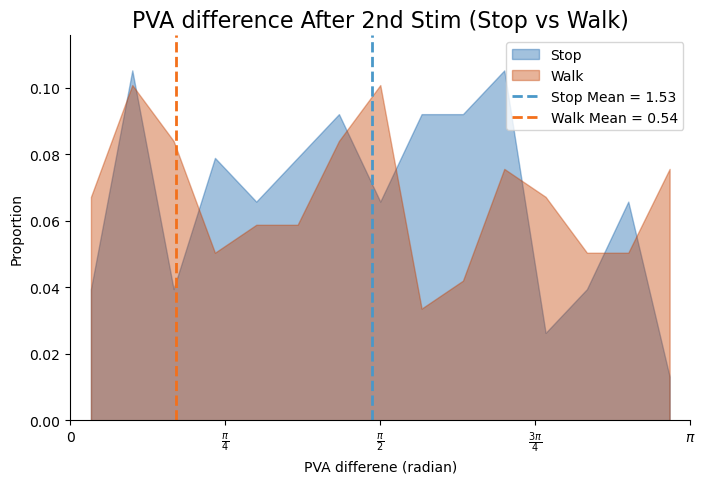

In [124]:
# Define bins
bins = np.linspace(0, np.pi, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['PVA_difference'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['PVA_difference'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(np.abs(stop_data), bins=bins)
hist_walk, _ = np.histogram(np.abs(walk_data), bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute circular means, ignoring NaNs
circ_mean_stop = circmean(np.abs(stop_data.dropna()), high=np.pi, low=0)
circ_mean_walk = circmean(np.abs(walk_data.dropna()), high=np.pi, low=0)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

# Plot circular means as dashed lines
ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(0, np.pi)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xticks([0,np.pi/4, np.pi/2, np.pi*3/4, np.pi])
ax.set_xticklabels(['0', r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r'$\pi$'])
ax.set_xlabel("PVA differene (radian)")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("PVA difference After 2nd Stim (Stop vs Walk)", fontsize=16)

plt.show()

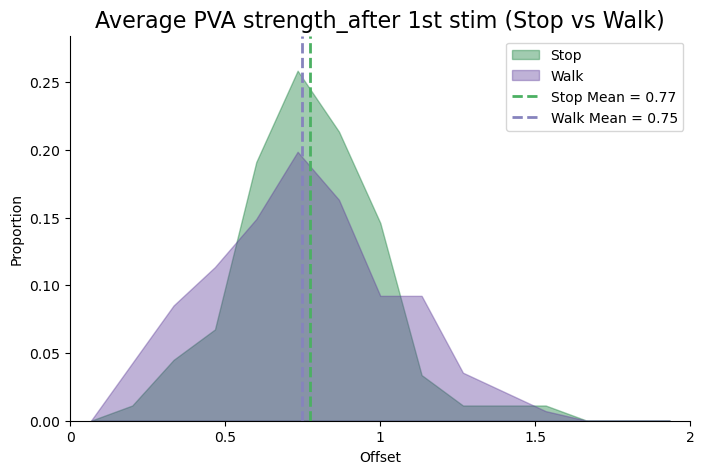

In [125]:
# Define bins
bins = np.linspace(0, 2, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['average_strength_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['average_strength_after_1st_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(stop_data, bins=bins)
hist_walk, _ = np.histogram(walk_data, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute cmeans, ignoring NaNs
mean_stop =np.mean(stop_data.dropna())
mean_walk = np.mean(walk_data.dropna())

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Greens(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Purples(0.8), label="Walk")

# Plot means as dashed lines
ax.axvline(mean_stop, color=plt.cm.Greens(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {mean_stop:.2f}')
ax.axvline(mean_walk, color=plt.cm.Purples(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {mean_walk:.2f}')

# Formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_xticklabels([r'0', r'0.5', '1', r'1.5', r'2'])
ax.set_xlabel("Offset")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Average PVA strength_after 1st stim (Stop vs Walk)", fontsize=16)

plt.show()

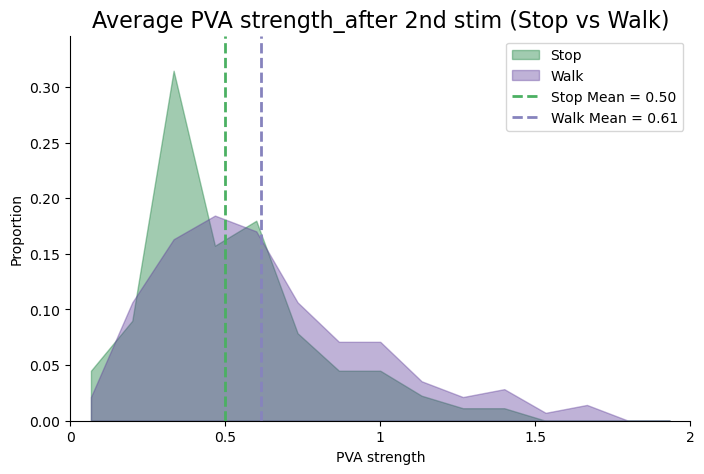

In [126]:
# Define bins
bins = np.linspace(0, 2, num=16)

# Extract data for both conditions (removing NaNs)
stop_data = data['average_strength_after_2nd_stim'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['average_strength_after_2nd_stim'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Compute histograms
hist_stop, _ = np.histogram(stop_data, bins=bins)
hist_walk, _ = np.histogram(walk_data, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute  means, ignoring NaNs
mean_stop =np.mean(stop_data.dropna())
mean_walk = np.mean(walk_data.dropna())

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Greens(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Purples(0.8), label="Walk")

# Plot circular means as dashed lines
ax.axvline(mean_stop, color=plt.cm.Greens(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {mean_stop:.2f}')
ax.axvline(mean_walk, color=plt.cm.Purples(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {mean_walk:.2f}')

# Formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)  # Adjust y-limit for visibility
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_xticklabels([r'0', r'0.5', '1', r'1.5', r'2'])
ax.set_xlabel("PVA strength")
ax.set_ylabel("Proportion")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Average PVA strength_after 2nd stim (Stop vs Walk)", fontsize=16)

plt.show()

In [144]:
# Remove PVA_difference where either strength column has values smaller than 0.4
data['PVA_difference_PVA_threholded'] = data['PVA_difference'].where(
    (data['average_strength_after_1st_stim'] >= 0.2) & (data['average_strength_after_2nd_stim'] >= 0.4),
    np.nan  # Replace removed values with NaN
)

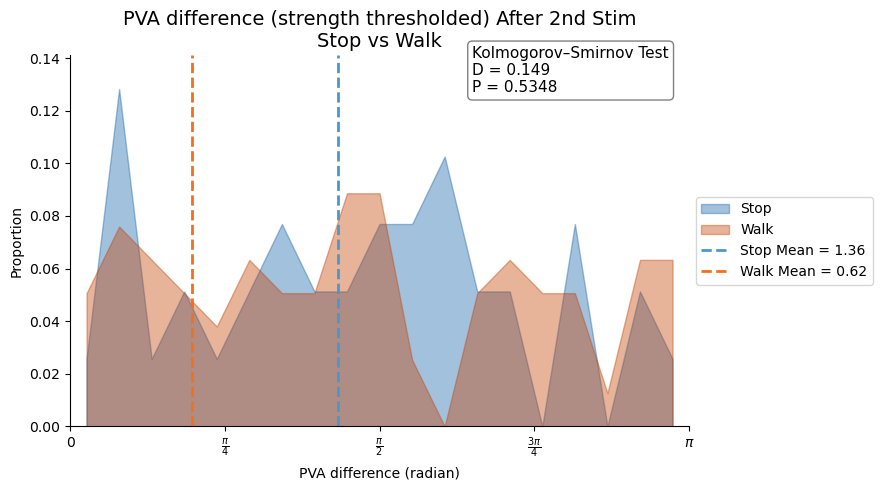

In [145]:
# Define bins
bins = np.linspace(0, np.pi, num=20)

# Extract and clean data
stop_data = data['PVA_difference_PVA_threholded'][data['stop_stamp_after_2nd_stim'] == 0].dropna()
walk_data = data['PVA_difference_PVA_threholded'][data['stop_stamp_after_2nd_stim'] == 1].dropna()

# Convert to absolute values
stop_abs = np.abs(stop_data.to_numpy())
walk_abs = np.abs(walk_data.to_numpy())

# Compute histograms
hist_stop, _ = np.histogram(stop_abs, bins=bins)
hist_walk, _ = np.histogram(walk_abs, bins=bins)

# Normalize to proportion
hist_stop = hist_stop / hist_stop.sum()
hist_walk = hist_walk / hist_walk.sum()

# Bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute circular means
circ_mean_stop = circmean(stop_abs, high=np.pi, low=0)
circ_mean_walk = circmean(walk_abs, high=np.pi, low=0)

# Perform Kolmogorov–Smirnov test
ks_stat, p_val = ks_2samp(stop_abs.flatten(), walk_abs.flatten())
ks_stat = float(ks_stat)
p_val = float(p_val)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

# Plot circular means
ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2, label=f'Stop Mean = {circ_mean_stop:.2f}')
ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2, label=f'Walk Mean = {circ_mean_walk:.2f}')

# Formatting
ax.set_xlim(0, np.pi)
ax.set_ylim(0, max(max(hist_stop), max(hist_walk)) * 1.1)
ax.set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax.set_xticklabels(['0', r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r'$\pi$'])
ax.set_xlabel("PVA difference (radian)")
ax.set_ylabel("Proportion")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("PVA difference (strength thresholded) After 2nd Stim\nStop vs Walk", fontsize=14)

# Add legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Annotate stats away from legend
ax.text(0.65, 0.9,
        f"Kolmogorov–Smirnov Test\nD = {ks_stat:.3f}\nP = {p_val:.4g}",
        transform=ax.transAxes,
        fontsize=11,
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

In [150]:
def plot_pva_difference_histogram(data, min_pva_diff=None):
    """
    Plot PVA difference histograms for stop vs walk trials, with optional filtering
    based on minimum PVA difference threshold. Performs a Kolmogorov–Smirnov test.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'PVA_difference_PVA_threholded'
                             and 'stop_stamp_after_2nd_stim'.
        min_pva_diff (float or None): Optional threshold (in radians); only include
                                      trials with abs(PVA difference) > threshold.
    """

    # Define bins
    bins = np.linspace(0, np.pi, num=16)

    # Extract and clean data
    all_diffs = data['PVA_difference_PVA_threholded']
    stop_mask = data['stop_stamp_after_2nd_stim'] == 0
    walk_mask = data['stop_stamp_after_2nd_stim'] == 1

    stop_data = all_diffs[stop_mask].dropna().to_numpy()
    walk_data = all_diffs[walk_mask].dropna().to_numpy()

    # Apply minimum PVA difference threshold if specified
    stop_abs = np.abs(stop_data)
    walk_abs = np.abs(walk_data)

    if min_pva_diff is not None:
        stop_abs = stop_abs[stop_abs > min_pva_diff]
        walk_abs = walk_abs[walk_abs > min_pva_diff]

    # Compute histograms
    hist_stop, _ = np.histogram(stop_abs, bins=bins)
    hist_walk, _ = np.histogram(walk_abs, bins=bins)

    # Normalize to proportion
    hist_stop = hist_stop / hist_stop.sum() if hist_stop.sum() > 0 else hist_stop
    hist_walk = hist_walk / hist_walk.sum() if hist_walk.sum() > 0 else hist_walk

    # Bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Compute circular means
    circ_mean_stop = circmean(stop_abs, high=np.pi, low=0) if len(stop_abs) > 0 else np.nan
    circ_mean_walk = circmean(walk_abs, high=np.pi, low=0) if len(walk_abs) > 0 else np.nan

    # Kolmogorov–Smirnov test
    if len(stop_abs) > 0 and len(walk_abs) > 0:
        ks_stat, p_val = ks_2samp(stop_abs.flatten(), walk_abs.flatten())
        ks_stat = float(ks_stat)
        p_val = float(p_val)
        stat_text = f"Kolmogorov–Smirnov Test\nD = {ks_stat:.3f}\nP = {p_val:.4g}"
    else:
        stat_text = "Not enough data for K–S test"

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.fill_between(bin_centers, hist_stop, alpha=0.4, color=plt.cm.Blues(0.8), label="Stop")
    ax.fill_between(bin_centers, hist_walk, alpha=0.4, color=plt.cm.Oranges(0.8), label="Walk")

    if not np.isnan(circ_mean_stop):
        ax.axvline(circ_mean_stop, color=plt.cm.Blues(0.6), linestyle='dashed', linewidth=2,
                   label=f'Stop Mean = {circ_mean_stop:.2f}')
    if not np.isnan(circ_mean_walk):
        ax.axvline(circ_mean_walk, color=plt.cm.Oranges(0.6), linestyle='dashed', linewidth=2,
                   label=f'Walk Mean = {circ_mean_walk:.2f}')

    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, max(max(hist_stop, default=0), max(hist_walk, default=0)) * 1.1)
    ax.set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
    ax.set_xticklabels(['0', r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r'$\pi$'])
    ax.set_xlabel("PVA difference (radian)")
    ax.set_ylabel("Proportion")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("PVA Difference After 2nd Stim\nStop vs Walk", fontsize=14)

    # Adjust for legend and add
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Annotate stats away from legend
    ax.text(0.65, 0.9,
            stat_text,
            transform=ax.transAxes,
            fontsize=11,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    plt.tight_layout()
    plt.show()

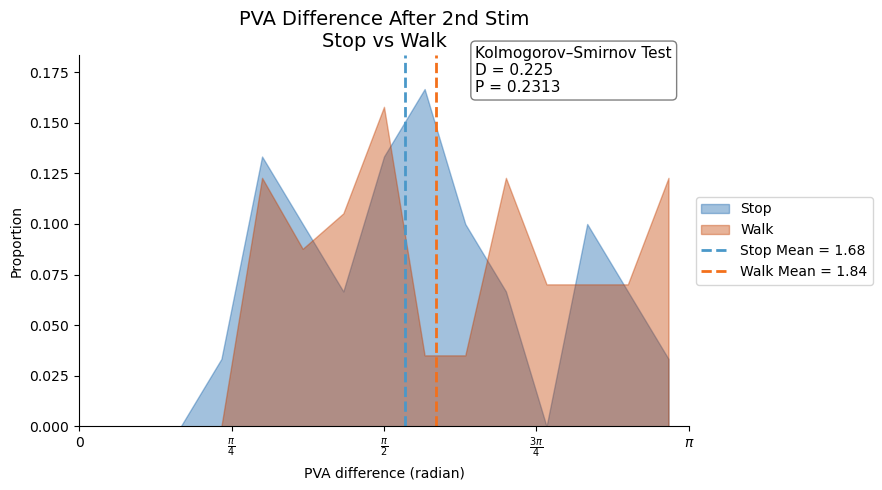

In [152]:
plot_pva_difference_histogram(data, min_pva_diff=np.pi / 4)

In [148]:
len(stop_data)

39

In [149]:
len(walk_data)

79